In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo, z_at_value
import coop_post_processing as cpp
from scipy import ndimage
import coop_setup_funcs as csf
import warnings
from astropy.visualization import quantity_support
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
# set plot params
import matplotlib as mpl
import scipy as sp
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
import healpy as hp

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import stats as st

In [3]:
# Define the distance bins
dbins = [[893, 1393], [1493, 1993], [2093, 2593], [2693,3193]]
for dbin in dbins:
    print(z_at_value(cosmo.comoving_distance, (dbin[0]-50)*u.Mpc),z_at_value(cosmo.comoving_distance, (dbin[1]+50)*u.Mpc))

zbins = ['0pt20_0pt36', '0pt36_0pt53', '0pt53_0pt72', '0pt72_0pt94'] # the z bins for number density maps
actpath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"
mask =  "/mnt/raid-cita/mlokken/data/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask_hpx_4096.fits"

0.19985555905328484 redshift 0.3565167560560754 redshift
0.3565167560560754 redshift 0.5289988643902372 redshift
0.5289988643902372 redshift 0.7215854982816572 redshift
0.7215854982816572 redshift 0.9396687416637612 redshift


## First we will work with the fiducial setup:
- $\nu>2$, $e>0.3$
- 24 regions
- $\lambda>20$
- Orient with Hessian, X and Y positive gradients flipped towards horizontal / vertical
- 75 \% of Maglim data for orientation, 25 \% goes into number density maps

In [4]:
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24


## 1) Find out if region-weighting is necessary for the y map analysis

In [4]:
# Define a few functions for this test only
def reorder_wgts(wgtfile, acterrs):
    region_weights = np.loadtxt(wgtfile)
    actreg = np.asarray(acterrs['region']).astype(int)
    wgtlist = []
    for r in actreg:
        where = region_weights[:,0] == r
        w = region_weights[where][:,1]
        wgtlist.extend(w)
    return wgtlist

def errs_w_spatial_wgts(pkl,nreg,m, spatial_wgts):
    npks_reg = pkl['npks_list']
    ys_all_regions_full = []
    ys_all_regions_binned = []
    for reg in range(nreg):
        y_binned = pkl['binnedprof'][reg][:,m]
        y = pkl['prof'][reg][:,m]
        ys_all_regions_binned.append(y_binned)
        ys_all_regions_full.append(y)
    weights = npks_reg / np.average(npks_reg)
    weights *=spatial_wgts
    covmat_binned, cormat_binned = cpp.covariances(ys_all_regions_binned, weights, nreg)
    covmat_full, cormat_full = cpp.covariances(ys_all_regions_full, weights, nreg)
    errors_binned = np.sqrt(np.diag(covmat_binned))
    errors_full = np.sqrt(np.diag(covmat_full))
    return(covmat_full, cormat_full, errors_full, covmat_binned, cormat_binned, errors_binned, np.sum(npks_reg))



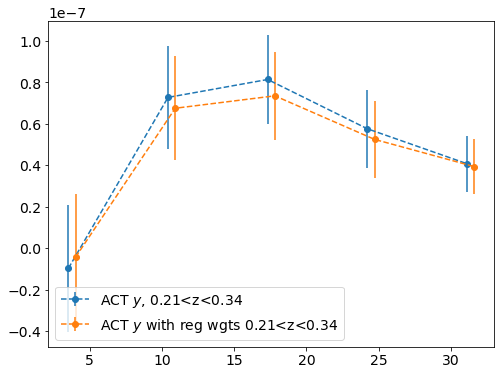

<Figure size 576x432 with 0 Axes>

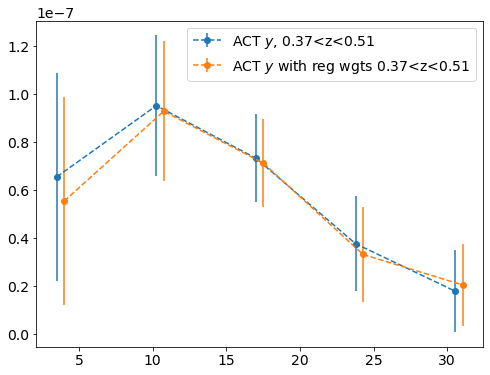

<Figure size 576x432 with 0 Axes>

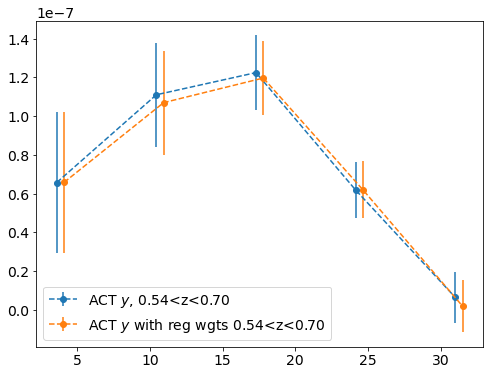

<Figure size 576x432 with 0 Axes>

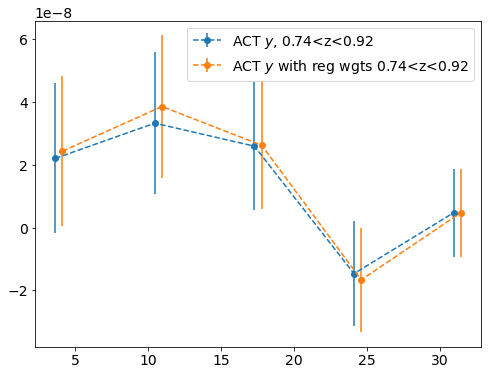

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

In [10]:
m=2
c=0
for dbin in dbins:
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    mapstr = f'ilc_SZ_deproj_cib_yy_4096_hpx'
    actfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg)
    acterrs   = np.load(actfile, allow_pickle=True)
    profs = np.asarray(acterrs['prof'])
    act_cibd = cpp.Stack_object(img_splits=acterrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=acterrs['npks_list'], rad_in_Mpc=acterrs['rad_in_Mpc'][4].value)
    act_cibd.bin_and_get_stats(7) #Mpc
    plt.errorbar(act_cibd.r_binned, act_cibd.avg_profiles_binned[m], yerr=act_cibd.errors_binned[m], fmt='o', linestyle='--', label='ACT $y$, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    wlist = reorder_wgts("/home/mlokken/oriented_stacking/act_only_code/noise_analysis/weights_24_regions_ACT_ilc_SZ_deproj_cib_yy_DES_redmapper_lambdagt20.txt", acterrs)
    act_cibd.set_split_wgts(additional_weights=wlist)
    act_cibd.set_average_profiles()
    act_cibd.bin_and_get_stats(7)
    plt.errorbar(act_cibd.r_binned+.5, act_cibd.avg_profiles_binned[m], yerr=act_cibd.errors_binned[m], fmt='o', linestyle='--', label='ACT $y$ with reg wgts {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value, color='orange'))
    plt.legend()
    plt.show()
    plt.clf()
    
    
    
    # plt.legend()
    # plt.ylabel("$y$")
    # plt.title(f"m={m}")
    # plt.xlabel("r [Mpc]")
    plt.show()
    plt.clf()
    # c+=1
    

Result: The errorbars are on average ~6% smaller for m=0, really similar otherwise

## 2) CIB deprojection: Compare CIB deprojected with nothing-deprojected

In [20]:
type(profs)

numpy.ndarray

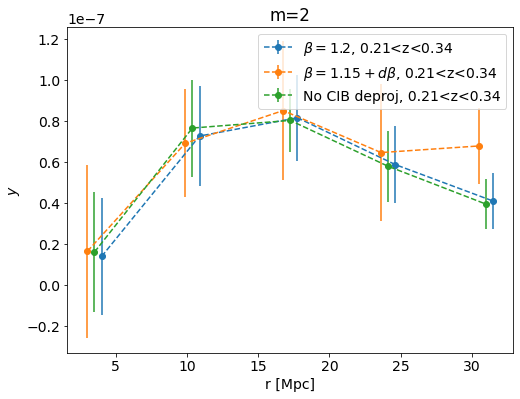

Chi-squared between beta=1.2, nothing deproj 0.05104807081120932
Chi-squared between beta=1.4, nothing deproj 2.1922816068010422
2.302130920562973 2.628898858118141 3.1248898150065587


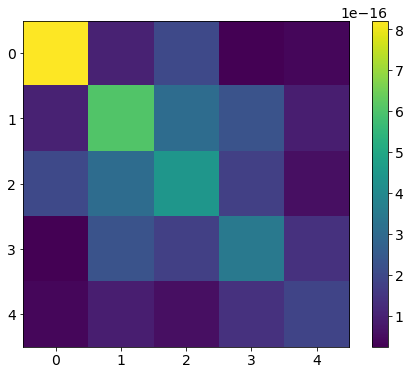

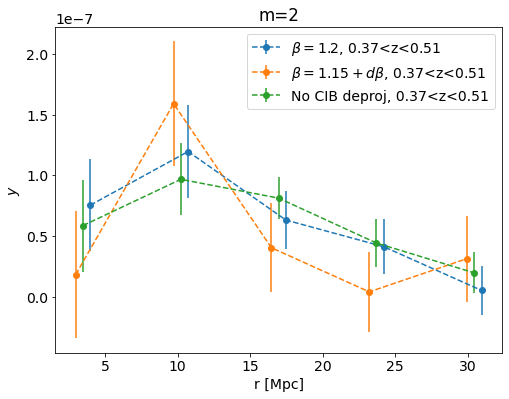

Chi-squared between beta=1.2, nothing deproj 1.0301949225185112
Chi-squared between beta=1.4, nothing deproj 8.859365444002291
2.251460612324209 1.788506870938869 2.590599481330824


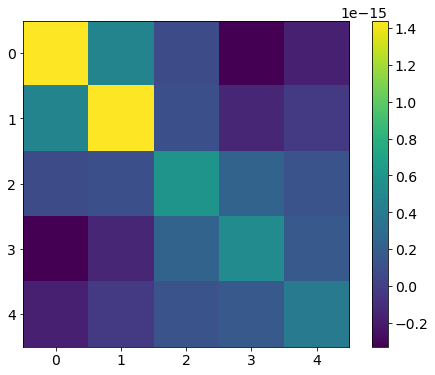

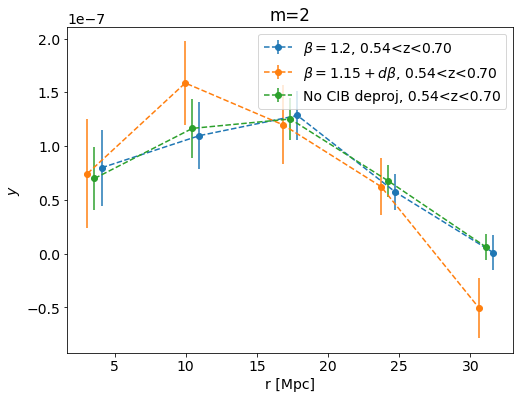

Chi-squared between beta=1.2, nothing deproj 0.39222946336939135
Chi-squared between beta=1.4, nothing deproj 4.410404816006709
3.26410628359461 2.4825362387833474 3.6135150804755054


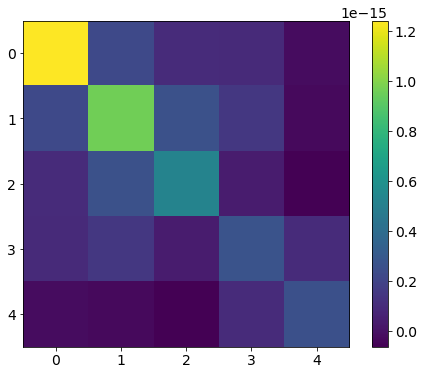

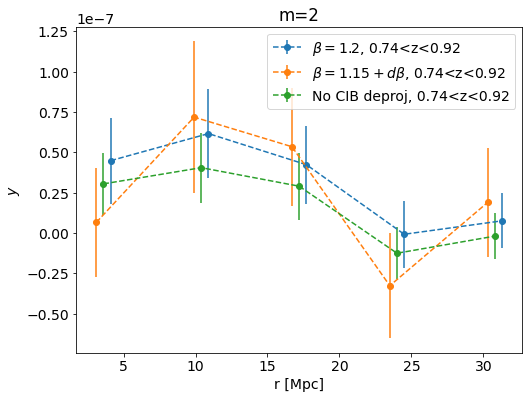

Chi-squared between beta=1.2, nothing deproj 0.9901193471722882
Chi-squared between beta=1.4, nothing deproj 2.293646252328313
1.502556687511369 1.374990655805306 1.371500508791839


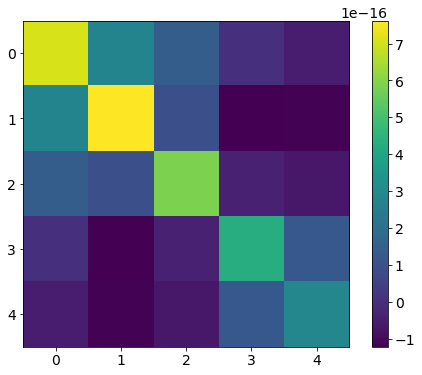

<Figure size 576x432 with 0 Axes>

In [23]:


# Comparing CIB-deprojected vs nothing-deprojected (deleted this run)
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24

b = 7
m=2
c=0
for dbin in dbins:
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    mapstr = f'ilc_SZ_deproj_cib_yy_4096_hpx'
    actfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg)
    acterrs = np.load(actfile, allow_pickle=True)
    profs = np.asarray(acterrs['prof'])
    act_cibd_fid = cpp.Stack_object(img_splits=acterrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=acterrs['npks_list'], rad_in_Mpc=40)
    act_cibd_fid.bin_and_get_stats(b) #Mpc
    plt.errorbar(act_cibd_fid.r_binned+.5, act_cibd_fid.avg_profiles_binned[m], yerr=act_cibd_fid.errors_binned[m], fmt='o', linestyle='--', label=r'$\beta=1.2$, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))

    mapstr = f'ilc_SZ_deproj_cib_cibdBeta_1.15_24.00_yy_4096_hpx'
    actfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg)
    acterrs = np.load(actfile, allow_pickle=True)
    profs = np.asarray(acterrs['prof'])
    act_cibd_1p15 = cpp.Stack_object(img_splits=acterrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=acterrs['npks_list'], rad_in_Mpc=40)
    act_cibd_1p15.bin_and_get_stats(b) #Mpc
    plt.errorbar(act_cibd_1p15.r_binned-.5, act_cibd_1p15.avg_profiles_binned[m], yerr=act_cibd_1p15.errors_binned[m], fmt='o', linestyle='--', label=r'$\beta=1.15 + d\beta$, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))

    mapstr = f'ilc_SZ_yy_4096_hpx'
    actfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg)
    acterrs   = np.load(actfile, allow_pickle=True)
    profs = np.asarray(acterrs['prof'])
    act_cibd_nodeproj = cpp.Stack_object(img_splits=acterrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=acterrs['npks_list'], rad_in_Mpc=40)
    act_cibd_nodeproj.bin_and_get_stats(b) #Mpc
    plt.errorbar(act_cibd_nodeproj.r_binned, act_cibd_nodeproj.avg_profiles_binned[m], yerr=act_cibd_nodeproj.errors_binned[m], fmt='o', linestyle='--', label=r'No CIB deproj, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    
    plt.legend()
    plt.ylabel("$y$")
    plt.title(f"m={m}")
    plt.xlabel("r [Mpc]")
    plt.show()
    plt.clf()
    
    # get the chi squared between each of these
    print("Chi-squared between beta=1.2, nothing deproj", st.chisq(act_cibd_fid.avg_profiles_binned[m], act_cibd_nodeproj.avg_profiles_binned[m], act_cibd_fid.covmat_binned[m], act_cibd_nodeproj.covmat_binned[m]))
    print("Chi-squared between beta=1.4, nothing deproj", st.chisq(act_cibd_1p15.avg_profiles_binned[m], act_cibd_nodeproj.avg_profiles_binned[m], act_cibd_1p15.covmat_binned[m], act_cibd_nodeproj.covmat_binned[m]))
    # chi squared with respect to null
    null_vector = np.zeros(len(act_cibd_fid.avg_profiles_binned[m]))
    print(np.sqrt(st.chisq(act_cibd_fid.avg_profiles_binned[m], null_vector, act_cibd_fid.covmat_binned[m])/4.), np.sqrt(st.chisq(act_cibd_1p15.avg_profiles_binned[m], null_vector, act_cibd_1p15.covmat_binned[m])/4.), np.sqrt(st.chisq(act_cibd_nodeproj.avg_profiles_binned[m], null_vector, act_cibd_nodeproj.covmat_binned[m])/4.))

    # print("SNR from PTE", st.snr_from_pte(act_cibd_fid.avg_profiles_binned[m], np.zeros(len(act_cibd_fid.avg_profiles_binned[m])), act_cibd_fid.covmat_binned[m]))
    plt.imshow(act_cibd_fid.covmat_binned[m])
    plt.colorbar()
    plt.show()
    plt.clf()
    c+=1
    

The following (commented) cell checks whether averaging the profiles from separate regions, weighted by npks, is equivalent to stacking a single time over the full map. It is perfect.

0.21239516461719793 redshift 0.3429098261022621 redshift



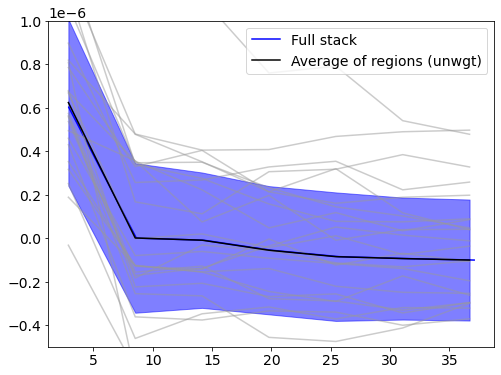

Fraction of regions beyond 1 sigma [0.29166667 0.41666667 0.375      0.29166667 0.33333333 0.375
 0.29166667]



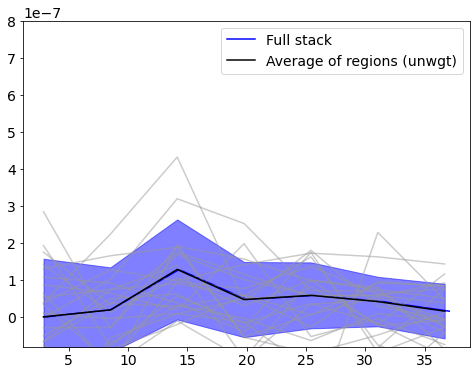

Fraction of regions beyond 1 sigma [0.29166667 0.25       0.25       0.33333333 0.41666667 0.29166667
 0.29166667]



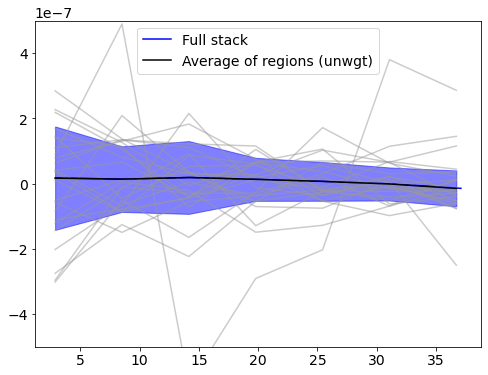

Fraction of regions beyond 1 sigma [0.33333333 0.41666667 0.20833333 0.33333333 0.33333333 0.45833333
 0.29166667]
0.3702330798213221 redshift 0.5139230139548906 redshift



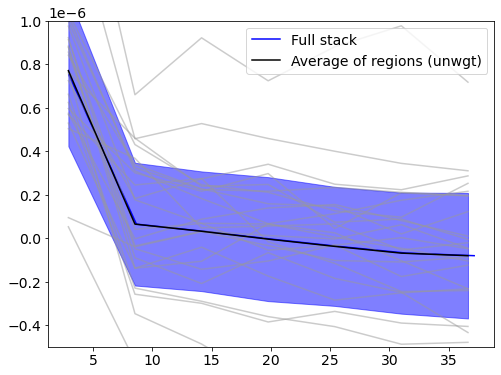

Fraction of regions beyond 1 sigma [0.16666667 0.375      0.25       0.33333333 0.29166667 0.33333333
 0.41666667]



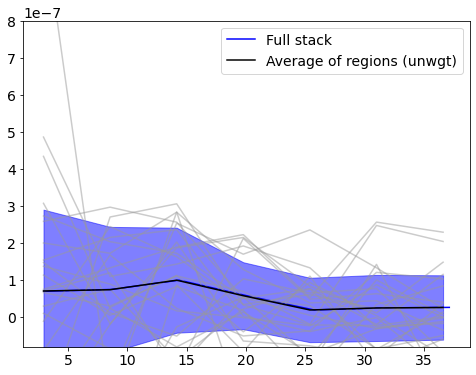

Fraction of regions beyond 1 sigma [0.375      0.29166667 0.41666667 0.41666667 0.33333333 0.375
 0.33333333]



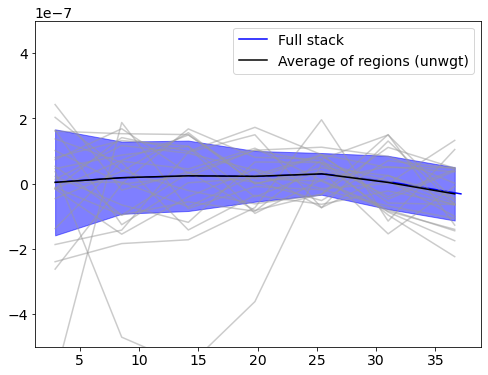

Fraction of regions beyond 1 sigma [0.25       0.5        0.33333333 0.45833333 0.25       0.41666667
 0.29166667]
0.544213697990799 redshift 0.7046457741840516 redshift



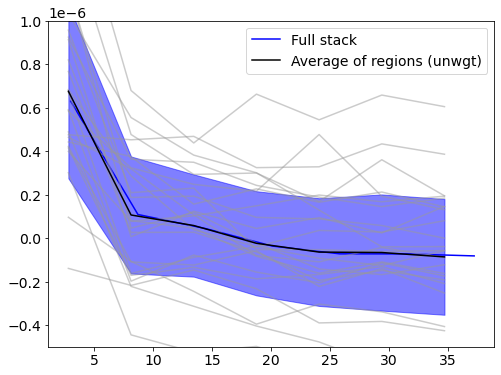

Fraction of regions beyond 1 sigma [0.25       0.41666667 0.33333333 0.41666667 0.33333333 0.33333333
 0.375     ]



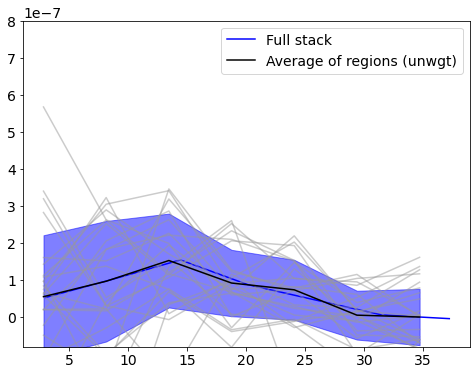

Fraction of regions beyond 1 sigma [0.33333333 0.41666667 0.29166667 0.41666667 0.33333333 0.33333333
 0.375     ]



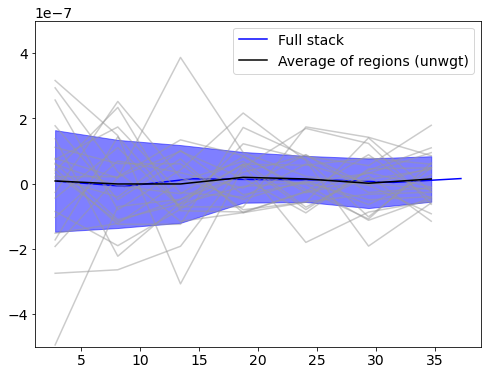

Fraction of regions beyond 1 sigma [0.375      0.33333333 0.20833333 0.33333333 0.375      0.41666667
 0.33333333]
0.7387014476605694 redshift 0.9203650420853864 redshift



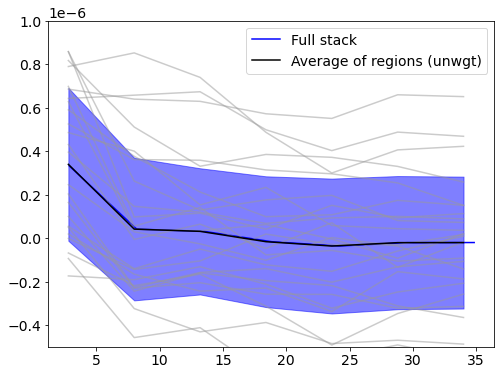

Fraction of regions beyond 1 sigma [0.33333333 0.33333333 0.29166667 0.29166667 0.33333333 0.29166667
 0.25      ]



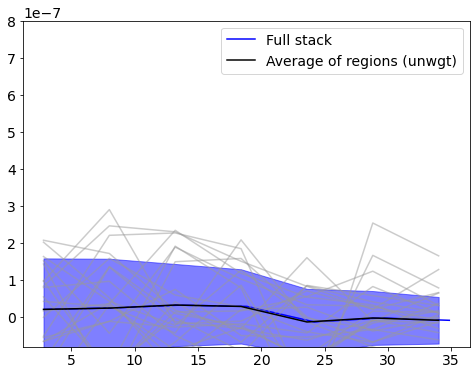

Fraction of regions beyond 1 sigma [0.41666667 0.5        0.41666667 0.33333333 0.5        0.29166667
 0.33333333]



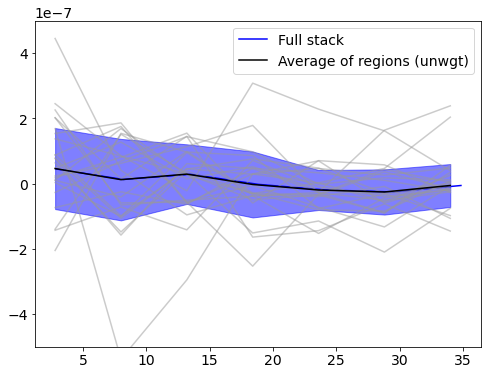

Fraction of regions beyond 1 sigma [0.33333333 0.33333333 0.29166667 0.20833333 0.33333333 0.25
 0.25      ]


<Figure size 576x432 with 0 Axes>

In [25]:
# Making sure errors make sense

for dbin in dbins:
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    print(zlow, zhi)
    mapstr = "ilc_SZ_deproj_cib_yy_4096_hpx"
    errs   = np.load("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg), allow_pickle=True)
    full   = np.load("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg), allow_pickle=True)
    profs = np.asarray(errs['prof'])
    act = cpp.Stack_object(img_splits=errs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=errs['npks_list'], rad_in_Mpc=40)
    act.bin_and_get_stats(5.7) #Mpc
    
    for m in [0,2,4]:
        plt.plot(full['binned_r'], full['binnedprof'][:,m], 'blue', label='Full stack')
        plt.fill_between(act.r_binned, act.avg_profiles_binned[m]-act.errors_binned[m]*np.sqrt(act.Nsamples), act.avg_profiles_binned[m]+act.errors_binned[m]*np.sqrt(act.Nsamples), color='blue', alpha=.5)
        is_beyond_1sigma = []
        for reg in range(24):
            plt.plot(act.r_binned, act.profile_splits_binned[m][reg], '.6', alpha=.5)
            is_beyond_1sigma.append(np.abs(act.profile_splits_binned[m][reg]-act.avg_profiles_binned[m]) > act.errors_binned[m]*np.sqrt(act.Nsamples))
        plt.plot(act.r_binned, act.avg_profiles_binned[m], 'k', label='Average of regions (unwgt)')

        print()
        if m==0:
            plt.ylim([-5e-7, 1e-6])
        if m==2:
            plt.ylim([-8e-8, 8e-7])
        if m==4:
            plt.ylim([-5e-7, 5e-7])
        plt.legend()
        plt.show()
        plt.clf()
        print("Fraction of regions beyond 1 sigma", np.sum(np.asarray(is_beyond_1sigma),axis=0)/24.)

    


# Evolution with Redshift

In [8]:
# y_avg = 1.58e-6 + 8.9e-8+ 9.8e-8 # In case I need it later


 First, no nu and e selection

0.21239516461719793 redshift 0.3429098261022621 redshift
60.12306035750604 7.753906135458827
0.3702330798213221 redshift 0.5139230139548906 redshift
52.0784079155495 7.216537113848268
0.544213697990799 redshift 0.7046457741840516 redshift
82.53866677759285 9.08507934899816
0.7387014476605694 redshift 0.9203650420853864 redshift
34.509789975809625 5.8745033812067575


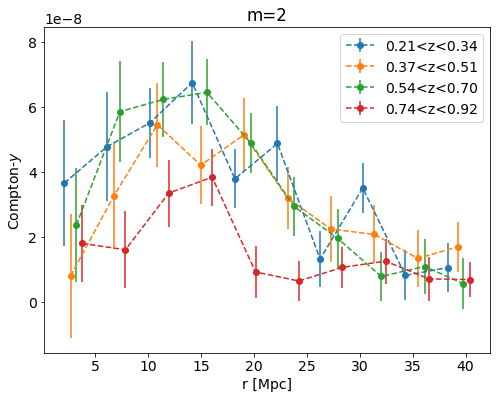

In [9]:
pt_selection_str = ''
c = 0
for dbin in dbins:
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    print(zlow, zhi)
    errs   = np.load("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/ilc_SZ_deproj_cib_yy_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orient_100pct_maglim_{:d}_{:d}Mpc_48reg_m0to5_profiles.pkl".format(cl_dlow, cl_dhi, pt_selection_str, dlow, dhi), allow_pickle=True)
    full   = np.load("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/ilc_SZ_deproj_cib_yy_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orient_100pct_maglim_{:d}_{:d}Mpc_m0to5_profiles.pkl".format(cl_dlow, cl_dhi, pt_selection_str, dlow, dhi), allow_pickle=True)
#     if c==0:
#         plt.imshow(cormat_binned)
#         plt.colorbar()
#         plt.show()
#         plt.clf()
    for m in [2]:
        covmat_full, cormat_full, errors_full, covmat_binned, cormat_binned, errors_binned, npks_tot = cpp.getprofs(errs, 48, m)
        avg = []
        plt.errorbar(full['binned_r']+np.full(len(full['binned_r']),c/2.), full['binnedprof'][:,m], yerr=errors_binned, fmt='o', linestyle='--', label='{:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    plt.legend()
    plt.ylabel("Compton-$y$")
    plt.title(f"m={m}")
    plt.xlabel("r [Mpc]")

    null = np.zeros(len(full['binnedprof'][:,m]))
    chisq_y = st.chisq(full['binnedprof'][:,m], null, covmat_binned)
    if m==2:
        snr_y = np.sqrt(chisq_y)
    elif m==4:
        snr_y = st.snr_from_pte( full['binnedprof'][:,m], null, covmat_binned, chisq_y)
    print(chisq_y, snr_y)
    
    
    c+=1
